In [105]:
pip install torch_geometric

In [106]:
pip install matplotlib seaborn

In [107]:
pip install mne

### EEG Data Extraction

In [43]:
# 
import numpy as np
import pandas as pd
import os
import scipy.io
import scipy.signal
import mne
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import time
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler

channelsList = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'CP3', 'CP4', 'CP5', 'CP6']

class SignalExtraction:

    @staticmethod
    def fn_signal_extraction_openneuro(raw_signal_obj, channels_subset=None):
        dict_x = {}
        for channel in raw_signal_obj.ch_names:
            signal_channel = raw_signal_obj[channel]
            y, x = signal_channel
            dict_x[channel] = y.flatten()
        signal_df = pd.DataFrame(dict_x)
        if channels_subset:
            signal_df = signal_df[channels_subset]
        signal_np = np.array(signal_df).transpose()
        return signal_np

    @staticmethod
    def get_participants_data_openneuro(file):
        df_participants = pd.read_csv(file, delimiter="\t")
        return df_participants

    @staticmethod
    def get_electrodes_coordinates(file, channelsList):
        df_coordinates = pd.read_csv(file, delimiter="\t")
        df1 = df_coordinates[df_coordinates.name.map(lambda x: x in channelsList)]
        df2 = df1.set_index('name')
        df3 = df2.reindex(channelsList)
        return df3

    @staticmethod
    def fn_label_extraction_openneuro(subject, df):
        BDI_obj = df[df.participant_id == subject].BDI
        return BDI_obj.values[0]

    @staticmethod
    def read_mne_iterator(path, num=None):
        lst = []
        i = 0
        df = SignalExtraction.get_participants_data_openneuro(os.path.join(path, 'participants.tsv'))

        def fn_read_EEG(root, run, channelsList):
            set_file = run['set']
            coordiantes_file = run['electrodes']
            name_split = set_file.split('_')
            subject_id = name_split[0] + '_' + name_split[2]
            bdi = SignalExtraction.fn_label_extraction_openneuro(name_split[0], df)
            mne_file = os.path.join(root, set_file)
            mne_obj = mne.io.read_raw_eeglab(mne_file)
            signal_np = SignalExtraction.fn_signal_extraction_openneuro(mne_obj, channelsList)
            coordiantesFile = os.path.join(root, coordiantes_file)
            df_coordinates = SignalExtraction.get_electrodes_coordinates(coordiantesFile, channelsList)
            return subject_id, signal_np, df_coordinates, bdi

        for root, _, files in os.walk(path):
            # root_list.append(root)
            if root.endswith('eeg'):
                run2 = {}
                for name in files:
                    if '_run-01_' in name:
                        if '_eeg.set' in name:
                            run2['set'] = name
                        if '_electrodes.tsv' in name:
                            run2['electrodes'] = name

                print(f'<<<<<<<Processing {root}>>>>>>>')
                if run2:
                    try:
                        subject_id, signal_np, df_coordinates, bdi = fn_read_EEG(root, run2, channelsList)
                        lst.append((subject_id, signal_np, df_coordinates, bdi))
                        # Print the shape of the extracted signal
                        print(f"Subject ID: {subject_id}, Signal Shape: {signal_np.shape}")
                        # Print the first few rows of the extracted signal
                    except Exception as e:
                        print(f'<<<<<<<Error in {run2}: {e}>>>>>>>')
                        continue
                i += 1
                if num and i == num:
                    return lst
        return lst#,root_list


class SignalProcessing:

    @staticmethod
    def normalize_data(data):
        """
        Normalize the data using Z-score normalization.
        """
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(data.T).T  # Transpose to fit each channel separately, then transpose back
        return normalized_data

    @staticmethod
    def bandpass_filter(edges: list[float], sample_rate: float, poles: int, data: np.ndarray):
        sos = scipy.signal.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
        filtered_data = scipy.signal.sosfiltfilt(sos, data)
        return filtered_data

    @staticmethod
    def notch_filter(frequency_toRemove: float, quality_factor: float, sample_frequency: float, data: np.ndarray):
        b, a = scipy.signal.iirnotch(frequency_toRemove, quality_factor, sample_frequency)
        filtered_data = scipy.signal.filtfilt(b, a, data)
        return filtered_data

    @staticmethod
    def resample(data: np.ndarray, sample_frequency: float, downsample_frequency: float):
        n = data.shape[1]
        num = (n // sample_frequency) * downsample_frequency
        resampled_data = scipy.signal.resample(data, num, axis=1)
        return resampled_data

    @staticmethod
    def data_augmentation(signal, sample_freq: int, window_size: int, stride_size: int):
        N = signal.shape[1]
        f = window_size * sample_freq
        s = stride_size * sample_freq
        n = (N - f + s) // s
        lst = [signal[:, i*s:i*s + f] for i in range(n)]
        tensor = np.stack(lst, axis=0)
        return tensor

    @staticmethod
    def fn_tensor(signal, n_slices):
        signal_slices = np.hsplit(signal, n_slices)
        tensor = np.stack(signal_slices, axis=0)
        return tensor

    @staticmethod
    def tensor_generator(signal, sample_freq, time_slice_size):
        n = signal.shape[1]
        assert n % sample_freq == 0
        t = n // sample_freq
        assert t % time_slice_size == 0
        n_time_slices = t // time_slice_size
        return SignalProcessing.fn_tensor(signal, n_time_slices)

    @staticmethod
    def signal_processing(np_array, sample_freq, band_freq_range, downsample_freq, slice_size, sub_slice_size):
        bandpass_filter = partial(SignalProcessing.bandpass_filter, band_freq_range, sample_freq, 5)
        signal_processed1 = np.apply_along_axis(bandpass_filter, 1, np_array)
        signal_processed1 = SignalProcessing.normalize_data(signal_processed1)  # Normalize after bandpass filtering
        notch_filter = partial(SignalProcessing.notch_filter, 60, 30, sample_freq)
        signal_processed2 = np.apply_along_axis(notch_filter, 1, signal_processed1)
        signal_processed2 = np_array
        signal_processed2 = SignalProcessing.normalize_data(signal_processed2)  # Normalize after notch filtering
        signal_processed3 = SignalProcessing.resample(signal_processed2, sample_freq, downsample_freq)
        signal_processed3 = SignalProcessing.normalize_data(signal_processed3)  # Normalize after resampling

        window_size = slice_size
        stride_size = window_size
        signal_augmented = SignalProcessing.data_augmentation(signal_processed3, downsample_freq, window_size, stride_size)

        # Remove the first and last 10 seconds of all signals
        if(len(signal_augmented) > 20*downsample_freq):
            signal_augmented = signal_augmented[:, 10*downsample_freq:-10*downsample_freq]
        else:
            signal_augmented = signal_augmented[:, :]


        signal_augmented = SignalProcessing.normalize_data(signal_augmented.reshape(-1, signal_augmented.shape[-1])).reshape(signal_augmented.shape)  # Normalize after data augmentation
        signal_tensors = [SignalProcessing.tensor_generator(signal_slice, downsample_freq, sub_slice_size) for signal_slice in signal_augmented]
        tensor = np.stack(signal_tensors, axis=0)
        tensor = SignalProcessing.normalize_data(tensor.reshape(-1, tensor.shape[-1])).reshape(tensor.shape)  # Normalize after tensor generation
        return tensor

    @staticmethod
    def AdjMatrix(df_electrodes_coordinates):
        np_coordinates = np.array(df_electrodes_coordinates)
        _, b = np_coordinates.shape
        lst = []
        for i in range(b):
            f = np_coordinates[:, i]
            d = f.reshape(-1, 1) - f.reshape(1, -1)
            d_square = d**2
            lst.append(d_square)
        tensor = np.stack(lst, axis=0)
        tensor_dist_sq = tensor.sum(axis=0)
        tensor_dist = np.sqrt(tensor_dist_sq)
        max_val, min_val = tensor_dist.max(), tensor_dist.min()
        tensor_dist_norm = (tensor_dist - min_val) / (max_val - min_val)
        return tensor_dist_norm if np.linalg.det(tensor_dist_norm) else np.array([])

    @staticmethod
    def to_bdi_label(bdi):
        bdi_label = 0 if bdi < 17 else 1
        return bdi_label

    @staticmethod
    def to_h5(file_path, subject, signal_array, label, frequency):
        with h5py.File(file_path, "w") as hf:
            hf.create_dataset("subject", data=subject)
            hf.create_dataset("resampled_signal", data=signal_array)
            hf.create_dataset("resample_freq", data=frequency)
            hf.create_dataset("label", data=label)

    @staticmethod
    def signal_processing_iterator(data_lst, sample_freq, band_freq_range, downsample_freq, slice_size, sub_slice_size):
        correct_data_lst = []
        error_data_lst = []
        for subject_id, signal_np, df_coordinates, bdi in data_lst:
            try:
                signal_processed = SignalProcessing.signal_processing(signal_np, sample_freq, band_freq_range, downsample_freq, slice_size, sub_slice_size)
                Adj_dist_matrix = SignalProcessing.AdjMatrix(df_coordinates)
                bdi_label = SignalProcessing.to_bdi_label(bdi)
                if bdi_label in [0, 1] and Adj_dist_matrix.size:
                    correct_data_lst.append((subject_id, signal_processed, Adj_dist_matrix, bdi, bdi_label))
                else:
                    error_data_lst.append((subject_id, signal_processed, Adj_dist_matrix, bdi, bdi_label))
            except Exception as e:
                print(f"Error processing subject {subject_id}: {e}")
                error_data_lst.append((subject_id, None, None, bdi, None))

        return correct_data_lst, error_data_lst


class TrainingData:

    @staticmethod
    def signal_to_trainingData(signal_tuple):
        ls = []
        subject_id, signal_processed, Adj_dist_matrix, bdi, bdi_label = signal_tuple
        for signal_slice in signal_processed:
            ls.append((signal_slice, Adj_dist_matrix, bdi_label))
        return ls

    @staticmethod
    def trainingData_iterator(signal_tuples):
        ls = []
        for signal_tuple in signal_tuples:
            ls = ls + TrainingData.signal_to_trainingData(signal_tuple)
        return ls


def train_test_datasets(dataSet, batch_size, train_test_split):
    # Splitting the data into training and testing datasets
    train_size = int(len(dataSet) * train_test_split)
    test_size = len(dataSet) - train_size
    train_dataset, test_dataset = random_split(dataSet, [train_size, test_size])

    # Creating DataLoaders for training and testing datasets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader


root_path = '/content/drive/MyDrive/'
file_path_openneuro = 'EEG/'

file_path = root_path + file_path_openneuro

start = time.time()
ls = SignalExtraction.read_mne_iterator(file_path, None)#######
end = time.time()
print(f"Data extraction time: {end - start}")

sliceSize = 6
bandFreqRange = [40, 100]
downsampleFreq = 200
subSliceSize = 6
sampleFrequency = 500

# After Signal Processing
start = time.time()
training_data, error_data = SignalProcessing.signal_processing_iterator(ls, sampleFrequency, bandFreqRange, downsampleFreq, sliceSize, subSliceSize)
end = time.time()
print(f"Signal processing time: {end - start}")

print(f"Number of training data samples: {len(training_data)}")

# Creating a folder to save processed data
output_folder = "processed_data"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Saving processed data for each subject
for subject_id, signal_processed, Adj_dist_matrix, bdi, bdi_label in training_data:
    subject_folder = os.path.join(output_folder, subject_id)
    if not os.path.exists(subject_folder):
        os.makedirs(subject_folder)

    # Save processed data in the subject's folder
    np.save(os.path.join(subject_folder, "signal_processed.npy"), signal_processed)
    np.save(os.path.join(subject_folder, "Adj_dist_matrix.npy"), Adj_dist_matrix)
    np.save(os.path.join(subject_folder, "bdi_label.npy"), bdi_label)

X = TrainingData.trainingData_iterator(training_data)

# Distribution of categorical Variable
ls = []
for i in X:
    signal_slice, Adj_dist_matrix, bdi_label = i
    ls.append(bdi_label)

import builtins
print(len(ls), builtins.sum(ls), len(ls) - builtins.sum(ls))

dataSet = X
print(len(dataSet))

batch_size = 40
train_test_split = 0.7

train_dataloader, test_dataloader = train_test_datasets(dataSet, batch_size, train_test_split)

print(len(train_dataloader), len(test_dataloader), len(train_dataloader.dataset) + len(test_dataloader.dataset), (len(train_dataloader) - 1) * batch_size + len(test_dataloader))

# train_features_signal, train_features_adjMatrix, train_labels = next(iter(train_dataloader))
# test_features_signal, test_features_adjMatrix, test_labels = next(iter(test_dataloader))

# train_features_signal.shape, train_features_adjMatrix.shape, train_labels.shape, test_features_signal.shape, test_features_adjMatrix.shape, test_labels.shape

signal, Adj_dist_matrix, label = dataSet[0]
print(signal.shape, Adj_dist_matrix.shape, label, len(dataSet))

learning_rate = 2e-4
batch_size = 40
epochs = 5

timeSteps, nodesDim, nodeFeaturesDim = signal.shape
hidden_dim = 64           #
dropout_prob = 0.7        #
num_layers = 2


<<<<<<<Processing /content/drive/MyDrive/EEG/sub-001/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-001/eeg/sub-001_task-Rest_run-01_eeg.fdt
Subject ID: sub-001_run-01, Signal Shape: (16, 250734)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-007/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-007/eeg/sub-007_task-Rest_run-01_eeg.fdt
Subject ID: sub-007_run-01, Signal Shape: (16, 249234)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-010/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-010/eeg/sub-010_task-Rest_run-01_eeg.fdt
Subject ID: sub-010_run-01, Signal Shape: (16, 249874)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-115/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-115/eeg/sub-115_task-Rest_run-01_eeg.fdt
Subject ID: sub-115_run-01, Signal Shape: (16, 251320)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-060/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-060/eeg/sub-060_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-060_run-01, Signal Shape: (16, 248260)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-066/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-066/eeg/sub-066_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-066_run-01, Signal Shape: (16, 251320)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-111/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-111/eeg/sub-111_task-Rest_run-01_eeg.fdt
Subject ID: sub-111_run-01, Signal Shape: (16, 228060)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-088/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-088/eeg/sub-088_task-Rest_run-01_eeg.fdt
Subject ID: sub-088_run-01, Signal Shape: (16, 246620)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-016/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-016/eeg/sub-016_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-016_run-01, Signal Shape: (16, 214520)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-020/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-020/eeg/sub-020_task-Rest_run-01_eeg.fdt
Subject ID: sub-020_run-01, Signal Shape: (16, 251274)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-092/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-092/eeg/sub-092_task-Rest_run-01_eeg.fdt
Subject ID: sub-092_run-01, Signal Shape: (16, 227180)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-099/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-099/eeg/sub-099_task-Rest_run-01_eeg.fdt
Subject ID: sub-099_run-01, Signal Shape: (16, 251360)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-100/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-100/eeg/sub-100_task-Rest_run-01_eeg.fdt
Subject ID: sub-100_run-01, Signal Shape: (16, 247710)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-108/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-108/eeg/sub-108_task-Rest_run-01_eeg.fdt
Subje

<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-122_run-01, Signal Shape: (16, 290020)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-065/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-065/eeg/sub-065_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-065_run-01, Signal Shape: (16, 246560)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-080/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-080/eeg/sub-080_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-080_run-01, Signal Shape: (16, 230912)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-084/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-084/eeg/sub-084_task-Rest_run-01_eeg.fdt
Subject ID: sub-084_run-01, Signal Shape: (16, 248920)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-098/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-098/eeg/sub-098_task-Rest_run-01_eeg.fdt
Subject ID: sub-098_run-01, Signal Shape: (16, 248755)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-102/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-102/eeg/sub-102_task-Rest_run-01_eeg.fdt
Subject ID: sub-102_run-01, Signal Shape: (16, 248480)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-113/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-113/eeg/sub-113_task-Rest_run-01_eeg.fdt
Subject ID: sub-113_run-01, Signal Shape: (16, 253660)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-118/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-118/eeg/sub-118_task-Rest_run-01_eeg.fdt
Subje

<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-023_run-01, Signal Shape: (16, 255580)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-032/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-032/eeg/sub-032_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-032_run-01, Signal Shape: (16, 252597)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-033/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-033/eeg/sub-033_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-033_run-01, Signal Shape: (16, 169001)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-004/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-004/eeg/sub-004_task-Rest_run-01_eeg.fdt
Subject ID: sub-004_run-01, Signal Shape: (16, 263834)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-005/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-005/eeg/sub-005_task-Rest_run-01_eeg.fdt
Subject ID: sub-005_run-01, Signal Shape: (16, 244040)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-006/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-006/eeg/sub-006_task-Rest_run-01_eeg.fdt
Subject ID: sub-006_run-01, Signal Shape: (16, 261760)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-008/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-008/eeg/sub-008_task-Rest_run-01_eeg.fdt
Subject ID: sub-008_run-01, Signal Shape: (16, 246340)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-009/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-009/eeg/sub-009_task-Rest_run-01_eeg.fdt
Subje

<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-014_run-01, Signal Shape: (16, 250700)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-015/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-015/eeg/sub-015_task-Rest_run-01_eeg.fdt
Subject ID: sub-015_run-01, Signal Shape: (16, 255390)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-012/eeg>>>>>>>
<<<<<<<Error in {'electrodes': 'sub-012_task-Rest_run-01_electrodes.tsv'}: 'set'>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-017/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-017/eeg/sub-017_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-017_run-01, Signal Shape: (16, 249960)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-018/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-018/eeg/sub-018_task-Rest_run-01_eeg.fdt
Subject ID: sub-018_run-01, Signal Shape: (16, 250780)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-019/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-019/eeg/sub-019_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-019_run-01, Signal Shape: (16, 246934)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-021/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-021/eeg/sub-021_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-021_run-01, Signal Shape: (16, 245144)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-022/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-022/eeg/sub-022_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-022_run-01, Signal Shape: (16, 246874)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-101/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-101/eeg/sub-101_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-101_run-01, Signal Shape: (16, 244780)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-103/eeg>>>>>>>
<<<<<<<Error in {'electrodes': 'sub-103_task-Rest_run-01_electrodes.tsv'}: 'set'>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-097/eeg>>>>>>>
<<<<<<<Error in {'electrodes': 'sub-097_task-Rest_run-01_electrodes.tsv'}: 'set'>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-024/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-024/eeg/sub-024_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-024_run-01, Signal Shape: (16, 232420)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-026/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-026/eeg/sub-026_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-026_run-01, Signal Shape: (16, 246920)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-025/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-025/eeg/sub-025_task-Rest_run-01_eeg.fdt
Subject ID: sub-025_run-01, Signal Shape: (16, 256320)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-027/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-027/eeg/sub-027_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-027_run-01, Signal Shape: (16, 245854)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-086/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-086/eeg/sub-086_task-Rest_run-01_eeg.fdt
Subject ID: sub-086_run-01, Signal Shape: (16, 251040)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-081/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-081/eeg/sub-081_task-Rest_run-01_eeg.fdt
Subject ID: sub-081_run-01, Signal Shape: (16, 245820)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-085/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-085/eeg/sub-085_task-Rest_run-01_eeg.fdt
Subject ID: sub-085_run-01, Signal Shape: (16, 250735)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-058/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-058/eeg/sub-058_task-Rest_run-01_eeg.fdt
Subject ID: sub-058_run-01, Signal Shape: (16, 249180)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-059/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-059/eeg/sub-059_task-Rest_run-01_eeg.fdt
Subje

<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-028_run-01, Signal Shape: (16, 246634)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-107/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-107/eeg/sub-107_task-Rest_run-01_eeg.fdt
Subject ID: sub-107_run-01, Signal Shape: (16, 116692)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-109/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-109/eeg/sub-109_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-109_run-01, Signal Shape: (16, 241660)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-112/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-112/eeg/sub-112_task-Rest_run-01_eeg.fdt
Subject ID: sub-112_run-01, Signal Shape: (16, 247540)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-114/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-114/eeg/sub-114_task-Rest_run-01_eeg.fdt
Subject ID: sub-114_run-01, Signal Shape: (16, 246460)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-121/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-121/eeg/sub-121_task-Rest_run-01_eeg.fdt
Subject ID: sub-121_run-01, Signal Shape: (16, 257760)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-030/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-030/eeg/sub-030_task-Rest_run-01_eeg.fdt
Subject ID: sub-030_run-01, Signal Shape: (16, 225520)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-031/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-031/eeg/sub-031_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-031_run-01, Signal Shape: (16, 246780)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-035/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-035/eeg/sub-035_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-035_run-01, Signal Shape: (16, 250634)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-034/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-034/eeg/sub-034_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-034_run-01, Signal Shape: (16, 228941)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-120/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-120/eeg/sub-120_task-Rest_run-01_eeg.fdt
Subject ID: sub-120_run-01, Signal Shape: (16, 250160)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-119/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-119/eeg/sub-119_task-Rest_run-01_eeg.fdt
Subject ID: sub-119_run-01, Signal Shape: (16, 251900)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-036/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-036/eeg/sub-036_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-036_run-01, Signal Shape: (16, 251734)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-037/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-037/eeg/sub-037_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-037_run-01, Signal Shape: (16, 247260)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-039/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-039/eeg/sub-039_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-039_run-01, Signal Shape: (16, 248414)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-040/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-040/eeg/sub-040_task-Rest_run-01_eeg.fdt
Subject ID: sub-040_run-01, Signal Shape: (16, 243214)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-041/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-041/eeg/sub-041_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-041_run-01, Signal Shape: (16, 248631)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-042/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-042/eeg/sub-042_task-Rest_run-01_eeg.fdt
Subject ID: sub-042_run-01, Signal Shape: (16, 253414)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-043/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-043/eeg/sub-043_task-Rest_run-01_eeg.fdt
Subject ID: sub-043_run-01, Signal Shape: (16, 244014)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-044/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-044/eeg/sub-044_task-Rest_run-01_eeg.fdt
<<<<<<<Error in {'set': 'sub-044_task-Rest_run-01_eeg.set', 'electrodes': 'sub-044_task-Rest_run-01_electrodes.tsv'}: [Errno 2] No such file or directory: '/content/drive/MyDrive/EEG/sub-044/eeg/sub-044_task-Rest_run-01_eeg.fdt'>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-045/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-045/eeg/sub-045_task-Rest_run-01_eeg.fdt


<ipython-input-43-c0e7c88107ff>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-045_run-01, Signal Shape: (16, 244434)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-046/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-046/eeg/sub-046_task-Rest_run-01_eeg.fdt
Subject ID: sub-046_run-01, Signal Shape: (16, 259974)
Data extraction time: 895.4279131889343
Signal processing time: 69.9698314666748
Number of training data samples: 75
6090 2662 3428
6090
107 46 6090 4286
(1, 16, 1200) (16, 16) 0 6090


### Train and Test Loops

In [44]:
# Splitting the data into training and testing datasets
train_size = int(len(dataSet) * train_test_split)
test_size = len(dataSet) - train_size
train_dataset, test_dataset = random_split(dataSet, [train_size, test_size])

# Creating DataLoaders for training and testing datasets with drop_last=True
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # Set drop_last here
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # Set drop_last here


In [45]:
import pickle
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class EEGSignalDataset(Dataset):
    def __init__(self, training_data):
        training_data_transformed = self._transform(training_data)
        self.signals, self.Adj_dist_matrices, self.y = training_data_transformed

    def _transform(self, training_data):
        signals, Adj_dist_matrices, labels = [], [], []
        for signal, Adj_dist_matrix, label in training_data:
            torch_signal = torch.from_numpy(signal).float()
            torch_Adj_dist_matrix = torch.from_numpy(Adj_dist_matrix).float()
            label = float(label)
            signals.append(torch_signal)
            Adj_dist_matrices.append(torch_Adj_dist_matrix)
            labels.append(label)
        return signals, Adj_dist_matrices, labels

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.signals[idx], self.Adj_dist_matrices[idx], self.y[idx]


def train_test_datasets(dataset, batch_size, train_test_split):
    train_size = int(train_test_split * len(dataset))
    test_size = len(dataset) - train_size
    trainDataset, testDataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_dataset = EEGSignalDataset(trainDataset)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = EEGSignalDataset(testDataset)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, test_dataloader


def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X_Signal, X_AdjMatrixy, y) in enumerate(dataloader):
        y = y.long()
        # Compute prediction and loss
        pred = model(X_Signal, X_AdjMatrixy)
        loss = loss_fn(pred, y.float())
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X_Signal)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():

        def fn_bool(p, y, treshold):
            result = y*p+(1-y)*(1-p)
            return result > treshold

        for X_Signal, X_AdjMatrixy, y in dataloader:
            pred = model(X_Signal, X_AdjMatrixy)
            test_loss += loss_fn(pred, y.float()).item()
            probability = nn.functional.sigmoid(pred)
            correct += (fn_bool(probability, y.float(), 0.5)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



In [46]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X_Signal, X_AdjMatrixy, y) in enumerate(dataloader):
        y = y.long()
        # Compute prediction and loss
        pred = model(X_Signal, X_AdjMatrixy)
        loss = loss_fn(pred, y.float())
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X_Signal)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    accuracy = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():

        def fn_bool(p, y, treshold):
            result = y*p+(1-y)*(1-p)
            return result > treshold

        for X_Signal, X_AdjMatrixy, y in dataloader:
            pred = model(X_Signal, X_AdjMatrixy)
            test_loss += loss_fn(pred, y.float()).item()
            probability = nn.functional.sigmoid(pred)
            correct += (fn_bool(probability, y.float(), 0.5)).type(torch.float).sum().item()
            accuracy = correct / size

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return accuracy, size



### Baseline Model with Dense Layers

In [47]:
# %%
import pickle
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


# %%
class AGTG_Model(nn.Module):
        def __init__(self, nodes_dim, node_features_dim):
            super().__init__()
            self.E = nodes_dim   #
            self.F = node_features_dim
            self.P = nn.Parameter(torch.randn(self.E,self.E), requires_grad=True)
            self.Q = nn.Parameter(torch.randn(self.F,self.E), requires_grad=True)
            self.b = nn.Parameter(torch.randn(self.E,1), requires_grad=True)
            self.d = nn.Parameter(torch.randn(1), requires_grad=True)

        def D_Matrix(self, A):
             d = torch.sum(A, 1)
             d_inv_sqrt = d**(-(1/2))
             D_inv_sqrt = torch.diag(d_inv_sqrt)
             return D_inv_sqrt

        def forward(self, X, adjacency_matrix):
            I = torch.eye(self.E)
            PX = torch.matmul(self.P, X.float())
            PXQ = torch.matmul(PX, self.Q)
            A_cor = torch.abs(PXQ+self.b)
            A = nn.functional.relu(A_cor+adjacency_matrix*self.d)
            A_I = A+I
            D = self.D_Matrix(A_I)
            A_norm = torch.matmul(D, torch.matmul(A_I, D))
            return A_norm

# %%
class GCN_Layer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_prob=0.5):
        super().__init__()
        self.W = nn.Parameter(torch.FloatTensor(input_dim, output_dim))
        nn.init.xavier_uniform_(self.W)
        self.dropout_prob = dropout_prob

    def forward(self, x, adjacency_matrix):
        # Compute the input to the layer: ˆAXW
        AXW = torch.matmul(adjacency_matrix.float(), torch.matmul(x.float(), self.W))

        # Apply the ReLU activation function to the input of the layer: ReLU(ˆAXW)
        hidden_rep = torch.relu(AXW)

        # Apply dropout
        hidden_rep = nn.functional.dropout(hidden_rep, p=self.dropout_prob, training=self.training)

        return hidden_rep

# %%
class GCN_Model(nn.Module):
    def __init__(self, node_features_dim, hidden_dim, num_layers=2, dropout_prob=0.1):
        super().__init__()
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob

        self.gcn_layers = nn.ModuleList([self._create_gcn_layer(node_features_dim, hidden_dim) if i == 0
                                         else self._create_gcn_layer(hidden_dim, hidden_dim)
                                         for i in range(self.num_layers)])

    def _create_gcn_layer(self, input_dim, output_dim):
        return GCN_Layer(input_dim, output_dim, dropout_prob=self.dropout_prob)

    def forward(self, features, adaptive_adjacency_matrix):
        x = features
        layers = []
        for i in range(self.num_layers):
            assert self.num_layers==2
            x = self.gcn_layers[i](x, adaptive_adjacency_matrix)
            layers.append(x)
            y = torch.concat(layers, dim=1)
        return y

# %%
class GRU_Cell(nn.Module):
    def __init__(self, nodes_dim):
        E = nodes_dim
        super().__init__()

        self.Wr_x = nn.Parameter(torch.randn(E,E), requires_grad=True)
        self.Wr_h = nn.Parameter(torch.randn(E,E), requires_grad=True)
        self.br   = nn.Parameter(torch.randn(E,1), requires_grad=True)

        self.Wu_x = nn.Parameter(torch.randn(E,E), requires_grad=True)
        self.Wu_h = nn.Parameter(torch.randn(E,E), requires_grad=True)
        self.bu   = nn.Parameter(torch.randn(E,1), requires_grad=True)

        self.Wc_x = nn.Parameter(torch.randn(E,E), requires_grad=True)
        self.Wc_h = nn.Parameter(torch.randn(E,E), requires_grad=True)
        self.bc   = nn.Parameter(torch.randn(E,1), requires_grad=True)

    def forward(self, features_t_0, hidden_state_t_1):
        GCN_x_t_0, h_t_1 = features_t_0, hidden_state_t_1
        r_t_0 = nn.functional.sigmoid(torch.matmul(self.Wr_x, GCN_x_t_0)+torch.matmul(self.Wr_h, h_t_1)+self.br)
        u_t_0 = nn.functional.sigmoid(torch.matmul(self.Wu_x, GCN_x_t_0)+torch.matmul(self.Wu_h, h_t_1)+self.bu)
        c_t_0 = nn.functional.tanh(torch.matmul(self.Wc_x, GCN_x_t_0)+torch.matmul(self.Wc_h, torch.mul(r_t_0, h_t_1))+self.bc)
        h_t_0 = torch.mul(u_t_0, h_t_1)+torch.mul(1-u_t_0, c_t_0)
        return h_t_0

# %%
class GRU_Model(nn.Module):
    def __init__(self, nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len):
        super().__init__()
        self.Seq_len = Seq_len
        self.agtg_Adj_Matrix_layer = self._create_AGTG_Adj_Matrix(nodes_Dim, node_Features_Dim)
        self.gcn_model_layer = self._create_GCN_Model(node_Features_Dim, hidden_dim, num_layers, dropout_prob)
        self.gru_cell_layer = self._create_GRU_Cell(nodes_Dim)
        self.H_0 = torch.zeros(nodes_Dim, 2*hidden_dim)

    def _create_AGTG_Adj_Matrix(self, nodes_dim, node_features_dim):
        return AGTG_Model(nodes_dim, node_features_dim)

    def _create_GCN_Model(self, node_features_dim, hidden_dim, num_layers, dropout_prob):
        return GCN_Model(node_features_dim, hidden_dim, num_layers, dropout_prob)

    def _create_GRU_Cell(self, nodes_dim):
        return GRU_Cell(nodes_dim)

    def forward(self, input_seq, adjacency_matrix):
        x, adj = input_seq, adjacency_matrix
        steps, _, _ = x.shape
        assert self.Seq_len == steps

        H = self.H_0
        for i in range(self.Seq_len):
            adaptive_adj_i = self.agtg_Adj_Matrix_layer(x[i], adj)
            gcn_Gi = self.gcn_model_layer(x[i], adaptive_adj_i)
            gru_Hi = self.gru_cell_layer(gcn_Gi, H)
            H = gru_Hi
        return H, adaptive_adj_i

# %%
# class GraphTopologyMaxPooling_Model(nn.Module):
#     def __init__(self, nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len):
#         super().__init__()
#         self.E = nodes_Dim
#         self.W = nn.Parameter(torch.randn(2*hidden_dim,1), requires_grad=True)
#         self.b = nn.Parameter(torch.randn(nodes_Dim, 1), requires_grad=True)
#         self.W_logit = nn.Parameter(torch.randn(2*hidden_dim), requires_grad=True)
#         self.gru_Model = self._create_GRU_Model(nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len)

#     def _create_GRU_Model(self, nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len):
#         return GRU_Model(nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len)

#     def forward(self, input_seq, adjacency_matrix):
#         H, A = self.gru_Model(input_seq, adjacency_matrix)
#         AHW_b = torch.matmul(torch.matmul(A.float(), H.float()), self.W)+self.b
#         S_node = torch.relu(AHW_b)
#         N_idx = torch.argmax(S_node, dim=0)
#         mask__n_idx = torch.zeros(self.E, N_idx.shape[0]).scatter_(0, N_idx.unsqueeze(0), 1.)
#         V_graph = torch.mul(mask__n_idx, H)
#         logit = torch.matmul(torch.sum(V_graph, 0), self.W_logit)
#         return logit
class GraphTopologyMaxPooling_Model(nn.Module):
    def __init__(self, nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len):
        super().__init__()
        self.E = nodes_Dim
        self.W = nn.Parameter(torch.randn(2*hidden_dim,1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(nodes_Dim, 1), requires_grad=True)
        self.W_logit = nn.Parameter(torch.randn(2*hidden_dim,hidden_dim), requires_grad=True)
        self.gru_Model = self._create_GRU_Model(nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len)
        # Adding dense layers
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)

    def _create_GRU_Model(self, nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len):
        return GRU_Model(nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len)

    def forward(self, input_seq, adjacency_matrix):
        H, A = self.gru_Model(input_seq, adjacency_matrix)
        AHW_b = torch.matmul(torch.matmul(A.float(), H.float()), self.W)+self.b
        S_node = torch.relu(AHW_b)
        N_idx = torch.argmax(S_node, dim=0)
        mask__n_idx = torch.zeros(self.E, N_idx.shape[0]).scatter_(0, N_idx.unsqueeze(0), 1.)
        V_graph = torch.mul(mask__n_idx, H)
        a = V_graph
        logit = torch.matmul(a, self.W_logit)
        # Passing through dense layers
        #x = torch.sum(V_graph, 0)
        x = (self.fc1(logit))
        x = (self.fc2(x))
        x = (self.fc3(x))
        x = (self.fc4(x))
        x = torch.sum(x, 0)
        x = torch.sigmoid(x)
        return x.squeeze()


# %%
class Main_Model(nn.Module):

    def __init__(self, nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.maxPooling_Model = self._create_MaxPooling_Model(nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len)

    def _create_MaxPooling_Model(self, nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len):
        return GraphTopologyMaxPooling_Model(nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len)

    def forward(self, input_seq_batch, adjacency_matrix_batch):
        logits = []
        if input_seq_batch.shape[0] == self.batch_size:
                assert input_seq_batch.shape[0] == self.batch_size
                assert adjacency_matrix_batch.shape[0] == self.batch_size
        else:
            self.batch_size = input_seq_batch.shape[0]

        for i in range(self.batch_size):
            logit = self.maxPooling_Model(input_seq_batch[i], adjacency_matrix_batch[i])
            logits.append(logit)
        logit_vector = torch.stack(logits, dim=0)
        sigmoid_x = torch.sigmoid(logit_vector)

        return logit_vector

import pickle
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# X = TrainingData.trainingData_iterator(training_data)

# dataSet = X
# batch_size = 40
# train_test_split = 0.8


# train_dataloader, test_dataloader = train_test_datasets(dataSet, batch_size, train_test_split)

learning_rate = 2e-3
timeSteps, nodesDim, nodeFeaturesDim = dataSet[0][0].shape
node_features_dim = 50
hidden_dim = 64
hidden_dim = 64
dropout_prob = 0.3
num_layers = 2

model = Main_Model(nodesDim, nodeFeaturesDim, hidden_dim, num_layers, dropout_prob,timeSteps, batch_size)
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 20
weights = []
for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loop(train_dataloader, model, loss_fn, optimizer, batch_size)
    test_loop(test_dataloader, model, loss_fn)
   # print(model.maxPooling_Model.gru_Model.gru_cell_layer.Wr_x)
    weights.append(model.maxPooling_Model.gru_Model.gru_cell_layer.Wr_x.detach().numpy())
print("Done!")


Epoch 1
loss: 0.813881  [   40/ 4263]
loss: 0.690360  [ 4040/ 4263]
Test Error: 
 Accuracy: 42.5%, Avg loss: 0.704565 

Epoch 2
loss: 0.691096  [   40/ 4263]
loss: 0.696038  [ 4040/ 4263]
Test Error: 
 Accuracy: 42.5%, Avg loss: 0.698625 

Epoch 3
loss: 0.699014  [   40/ 4263]
loss: 0.697538  [ 4040/ 4263]
Test Error: 
 Accuracy: 42.5%, Avg loss: 0.696750 

Epoch 4
loss: 0.699370  [   40/ 4263]
loss: 0.694780  [ 4040/ 4263]
Test Error: 
 Accuracy: 42.5%, Avg loss: 0.695824 

Epoch 5
loss: 0.703715  [   40/ 4263]
loss: 0.695794  [ 4040/ 4263]
Test Error: 
 Accuracy: 42.5%, Avg loss: 0.695272 

Epoch 6
loss: 0.697221  [   40/ 4263]
loss: 0.692984  [ 4040/ 4263]
Test Error: 
 Accuracy: 42.5%, Avg loss: 0.694951 

Epoch 7
loss: 0.692575  [   40/ 4263]
loss: 0.700505  [ 4040/ 4263]
Test Error: 
 Accuracy: 42.5%, Avg loss: 0.694695 

Epoch 8
loss: 0.700389  [   40/ 4263]
loss: 0.694073  [ 4040/ 4263]
Test Error: 
 Accuracy: 42.5%, Avg loss: 0.694502 

Epoch 9
loss: 0.691305  [   40/ 4263]
lo

In [48]:
full_sub_id = []
full_signals = []
full_Adj_dist_matrices = []
full_bdi_scores = []
full_labels = []
for i in range(20):
  sub_id = training_data[i][0]
  sub_id_list = my_list = [sub_id] * len(training_data[i][1])

  signal_list = []
  signals = training_data[i][1]
  for j in range(len(signals)):
    signal_list.append(signals[j])
  signals = signal_list

  adj = training_data[i][2]
  A_list = [adj] * len(signals)

  bdi_score = training_data[i][3]
  bdi_score_list = [bdi_score] * len(signals)

  label = training_data[i][4]
  label_list = [label] * len(signals)

  full_sub_id += sub_id_list
  full_signals += signals
  full_Adj_dist_matrices += A_list
  full_bdi_scores += bdi_score_list
  full_labels += label_list

sub_id_train = full_sub_id[:round(0.8*len(full_sub_id))]
sub_id_test = full_sub_id[round(0.8*len(full_sub_id)):]

signals_train = full_signals[:round(0.8*len(full_signals))]
signals_test = full_signals[round(0.8*len(full_signals)):]

adj_train = full_Adj_dist_matrices[:round(0.8*len(full_Adj_dist_matrices))]
adj_test = full_Adj_dist_matrices[round(0.8*len(full_Adj_dist_matrices)):]

bdi_score_train = full_bdi_scores[:round(0.8*len(full_bdi_scores))]
bdi_score_test = full_bdi_scores[round(0.8*len(full_bdi_scores)):]

label_train = full_labels[:round(0.8*len(full_labels))]
label_test = full_labels[round(0.8*len(full_labels)):]

train_dataloader_processed_sub = DataLoader(list(zip(sub_id_train, signals_train,adj_train,bdi_score_train,label_train)), batch_size=32, shuffle=True)
test_dataloader_processed_sub = DataLoader(list(zip(sub_id_test, signals_test,adj_test,bdi_score_test,label_test)), batch_size=32, shuffle=True)

In [49]:
H_list_train = []
A_list_train = []
sub_id_list_train = []
label_list_train = []
for i,j,k,l,m in train_dataloader_processed_sub:
  for n in range(len(i)):
    H, A = model.maxPooling_Model.gru_Model.forward(j[n], k[n])
    H_list_train.append(H)
    A_list_train.append(A)
    label_list_train.append(m[n])
    sub_id_list_train.append(i[n])

H_list_test = []
A_list_test = []
sub_id_list_test = []
label_list_test = []
for i,j,k,l,m in test_dataloader_processed_sub:
  for n in range(len(i)):
    H, A = model.maxPooling_Model.gru_Model.forward(j[n], k[n])
    H_list_test.append(H)
    A_list_test.append(A)
    label_list_test.append(m[n])
    sub_id_list_test.append(i[n])

for i in range(len(H_list_train)):
  sum = torch.zeros(128)
  for j in range(16):
    sum = sum + H_list_train[i][j]
  H_list_train[i] = sum/16

for i in range(len(H_list_test)):
  sum = torch.zeros(128)
  for j in range(16):
    sum = sum + H_list_test[i][j]
  H_list_test[i] = sum/16

train_dataloader_processed = DataLoader(list(zip(H_list_train,A_list_train, label_list_train)), batch_size=1, shuffle=True)
test_dataloader_processed = DataLoader(list(zip(H_list_test,A_list_test, label_list_test)), batch_size=1, shuffle=True)

In [50]:
class GraphTopologyMaxPooling_Model(nn.Module):
    def __init__(self, nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len):
        super().__init__()
        self.E = nodes_Dim
        self.W = nn.Parameter(torch.randn(2*hidden_dim,1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(nodes_Dim, 1), requires_grad=True)
        self.W_logit = nn.Parameter(torch.randn(2*hidden_dim,hidden_dim), requires_grad=True)
        self.gru_Model = self._create_GRU_Model(nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len)
        # Adding dense layers
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)

    def _create_GRU_Model(self, nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len):
        return GRU_Model(nodes_Dim, node_Features_Dim, hidden_dim, num_layers, dropout_prob, Seq_len)

    def forward(self, input_seq, adjacency_matrix):
        H, A = self.gru_Model(input_seq, adjacency_matrix)
        AHW_b = torch.matmul(torch.matmul(A.float(), H.float()), self.W)+self.b
        S_node = torch.relu(AHW_b)
        N_idx = torch.argmax(S_node, dim=0)
        mask__n_idx = torch.zeros(self.E, N_idx.shape[0]).scatter_(0, N_idx.unsqueeze(0), 1.)
        V_graph = torch.mul(mask__n_idx, H)
        a = V_graph
        logit = torch.matmul(a, self.W_logit)
        # Passing through dense layers
        #x = torch.sum(V_graph, 0)
        x1 = (self.fc1(logit))
        x2 = (self.fc2(x1))
        x3 = (self.fc3(x2))
        x4 = (self.fc4(x3))
        x5 = torch.sum(x4, 0)
        x6 = torch.sigmoid(x5)
        return  x1,x2,x3,x4,x5,x6

In [52]:

import random
# Assuming you have an instance of GraphTopologyMaxPooling_Model named 'gtmp_model' and appropriate input data
input_seq = None
adjacency_matrix = None
for i,j,k in train_dataloader:
  for l in range(len(i)):
    a = random.randint(0,len(i)-1)
    input_seq = i[a]
    adjacency_matrix = j[a]
    break
  break
gtmp_model = GraphTopologyMaxPooling_Model(nodesDim, nodeFeaturesDim, hidden_dim, num_layers, dropout_prob, timeSteps)
# Forward pass through the model to get V_graph
x1,x2,x3,x4,x5,x6 = gtmp_model(input_seq, adjacency_matrix)

# Get the shape of V_graph


print("logit in dense 1",x1)
print("Dense2",x2)
print("Dense3",x3)
print("Dense4",x4)
print("torch.sum",x5)
print("sigmoid",x6)


logit in dense 1 tensor([[-7.5267e-02,  8.3939e-02, -4.4970e-04, -1.0326e-01,  3.6755e-02,
          5.7748e-03,  1.0940e-02,  3.5182e-02,  1.1214e-01,  1.2485e-01,
          4.4389e-02,  3.3998e-02,  1.2252e-01, -4.0013e-02,  4.1975e-02,
          1.1815e-01, -1.1925e-01,  2.5253e-02, -4.8848e-02, -7.9324e-02,
         -9.5564e-02, -6.5531e-02, -7.3530e-02,  1.0404e-02, -7.3565e-02,
          6.7394e-02, -2.9482e-02, -7.0542e-03,  5.9177e-03,  6.1485e-02,
         -5.8108e-03, -2.9108e-02],
        [-7.5267e-02,  8.3939e-02, -4.4970e-04, -1.0326e-01,  3.6755e-02,
          5.7748e-03,  1.0940e-02,  3.5182e-02,  1.1214e-01,  1.2485e-01,
          4.4389e-02,  3.3998e-02,  1.2252e-01, -4.0013e-02,  4.1975e-02,
          1.1815e-01, -1.1925e-01,  2.5253e-02, -4.8848e-02, -7.9324e-02,
         -9.5564e-02, -6.5531e-02, -7.3530e-02,  1.0404e-02, -7.3565e-02,
          6.7394e-02, -2.9482e-02, -7.0542e-03,  5.9177e-03,  6.1485e-02,
         -5.8108e-03, -2.9108e-02],
        [-7.5267e-02,  

In [53]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)  # Calculate size here
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():

        def fn_bool(p, y, treshold):
            result = y*p+(1-y)*(1-p)
            return result > treshold

        for X_Signal, X_AdjMatrixy, y in dataloader:
            pred = model(X_Signal, X_AdjMatrixy)
            test_loss += loss_fn(pred, y.float()).item()
            probability = nn.functional.sigmoid(pred)
            correct += (fn_bool(probability, y.float(), 0.5)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    accuracy = 100 * correct  # Calculate accuracy here
    print(f"Test Error: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return accuracy, size # Added return statement to return accuracy and size

In [59]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

concatenated_tensor = concatenated_tensor.reshape(128,len(h_list))
cos_sim_matrix = cosine_similarity(concatenated_tensor.detach().numpy())  # Remove the reshape operation
threshold = 0.9
adjacency_matrix = np.where(cos_sim_matrix >= threshold, 1, 0)

In [60]:
adjacency_matrix.shape

(128, 128)

In [61]:
adj_list_train = [adjacency_matrix] * len(H_list_train)
adj_list_test = [adjacency_matrix] * len(H_list_test)

train_dataloader_new = DataLoader(list(zip(H_list_train,adj_list_train,label_train)), batch_size=1, shuffle=True)
test_dataloader_new = DataLoader(list(zip(H_list_test,adj_list_test,label_test)), batch_size=1, shuffle=True)

In [85]:
gcn_outputs = []
gcn_labels = []
for i,j,k in train_dataloader:
  for l in range(len(i)):
    input_seq = i[l]
    adjacency_matrix = j[l]
    H,A = model.maxPooling_Model.gru_Model.forward(input_seq, adjacency_matrix)
    gcn_output = model.maxPooling_Model.gru_Model.gcn_model_layer(input_seq,A)
    gcn_outputs.append(gcn_output.flatten())
    gcn_labels.append(k[l])



In [88]:
len(gcn_labels)

4240

In [98]:
for i in range(len(gcn_outputs)):
  gcn_outputs[i] = gcn_outputs[i].mean().detach().numpy()

In [99]:
gcn_0 = []
gcn_1 = []
for i in range(len(gcn_outputs)):
  if gcn_labels[i] == 0:
    gcn_0.append(gcn_outputs[i])
  else:
    gcn_1.append(gcn_outputs[i])

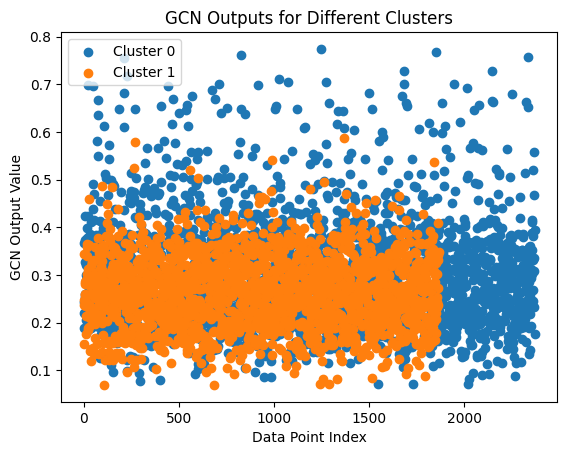

In [102]:
# prompt: plot gcn_0 and gcn_1 as clusters

import matplotlib.pyplot as plt

# Assuming gcn_0 and gcn_1 are lists of numerical values
plt.scatter(range(len(gcn_0)), gcn_0, label='Cluster 0')
plt.scatter(range(len(gcn_1)), gcn_1, label='Cluster 1')
plt.xlabel('Data Point Index')
plt.ylabel('GCN Output Value')
plt.title('GCN Outputs for Different Clusters')
plt.legend()
plt.show()


In [62]:

# prompt: make a gcn model for training_dataloader_new

import torch
import torch.nn as nn

class GCN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCN, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()
        # Added a sigmoid activation to get output in range [0,1] for BCELoss
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, adj):
        x = torch.matmul(adj.float(), x.reshape(128,1))
        x = self.fc(x.reshape(1,128))
        x = self.activation(x)
        # Apply sigmoid activation
        x = self.sigmoid(x)
        return x

# Create a GCN
gcn = GCN(128, 1)

# Train the GCN
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.1)

for epoch in range(100):
    for data, adj, labels in train_dataloader_new:
        # Ensure labels are float and have shape (batch_size, 128)
        labels = labels.float()
        # Forward pass
        outputs = gcn(data, adj)
        loss = criterion(outputs.reshape(1), labels.reshape(1))

        # Backward pass
        optimizer.zero_grad()
        #loss.backward()
        optimizer.step()

        # Zero out the gradients after updating the weights for the next iteration.
        optimizer.zero_grad()

    # Print the loss
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.6676
Epoch 2, Loss: 0.6931
Epoch 3, Loss: 0.6761
Epoch 4, Loss: 0.7357
Epoch 5, Loss: 0.6488
Epoch 6, Loss: 0.6931
Epoch 7, Loss: 0.6955
Epoch 8, Loss: 0.6931
Epoch 9, Loss: 0.6942
Epoch 10, Loss: 0.6686
Epoch 11, Loss: 0.6504
Epoch 12, Loss: 0.6782
Epoch 13, Loss: 0.7115
Epoch 14, Loss: 0.7247
Epoch 15, Loss: 0.6819
Epoch 16, Loss: 0.6892
Epoch 17, Loss: 0.6931
Epoch 18, Loss: 0.6931
Epoch 19, Loss: 0.6502
Epoch 20, Loss: 0.6505
Epoch 21, Loss: 0.6931
Epoch 22, Loss: 0.6931
Epoch 23, Loss: 0.6844
Epoch 24, Loss: 0.6712
Epoch 25, Loss: 0.6787
Epoch 26, Loss: 0.7690
Epoch 27, Loss: 0.6931
Epoch 28, Loss: 0.7244
Epoch 29, Loss: 0.6553
Epoch 30, Loss: 0.6553
Epoch 31, Loss: 0.6569
Epoch 32, Loss: 0.6430
Epoch 33, Loss: 0.6931
Epoch 34, Loss: 0.7179
Epoch 35, Loss: 0.6931
Epoch 36, Loss: 0.6736
Epoch 37, Loss: 0.6543
Epoch 38, Loss: 0.6663
Epoch 39, Loss: 0.6931
Epoch 40, Loss: 0.7191
Epoch 41, Loss: 0.6922
Epoch 42, Loss: 0.6718
Epoch 43, Loss: 0.6281
Epoch 44, Loss: 0.66

In [63]:
# prompt: get accuracy of above gcn

correct = 0
total = 0
with torch.no_grad():
    for data, adj, labels in train_dataloader_new:
        # Ensure labels are float and have shape (batch_size, 128)
        labels = labels.float()
        outputs = gcn(data, adj)
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy}")


Accuracy: 0.635392829900839


In [64]:
# prompt: save above model weights of gcn in h5 and download it
from google.colab import files
import h5py

# Save the model weights
with h5py.File('gcn_weights.h5', 'w') as f:
    for name, param in gcn.named_parameters():
        f.create_dataset(name, data=param.data.numpy())

# Download the file
files.download('gcn_weights.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:

from sklearn.metrics import confusion_matrix

# Get the predictions and labels
predictions = []
labels = []
for data, adj, label in test_dataloader_new:
  # Ensure labels are float and have shape (batch_size, 128)
  label = label.float()
  # Convert the model output to binary predictions
  prediction = (gcn(data, adj) > 0.5).float().item()
  predictions.append(prediction)
  labels.append(label.item())

# Create the confusion matrix
cm = confusion_matrix(labels, predictions)

# Print the confusion matrix
print(cm)

[[  0   0]
 [ 64 264]]


In [66]:
# ... (rest of the code)

# Get the predictions and labels
predictions = []
labels = []
for data, adj, label in train_dataloader_new:
    # Ensure labels are float and have shape (batch_size, 128)
    label = label.float()
    # Convert the model output to binary predictions
    prediction = (gcn(data, adj) > 0.5).float().item()  # Threshold at 0.5
    predictions.append(prediction)
    labels.append(label.item())

# Create the confusion matrix
cm = confusion_matrix(labels, predictions)

# Print the confusion matrix
print(cm)

[[ 73 330]
 [148 760]]


In [67]:
# Create a GCN
gcn_1 = GCN(128, 1)

# Train the GCN
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)

for epoch in range(100):
    for data, adj, labels in train_dataloader_new:
        # Ensure labels are float and have shape (batch_size, 128)
        labels = labels.float()
        # Forward pass
        outputs = gcn_1(data, adj)
        loss = criterion(outputs.reshape(1), labels.reshape(1))

        # Backward pass
        optimizer.zero_grad()
        #loss.backward()
        optimizer.step()

        # Zero out the gradients after updating the weights for the next iteration.
        optimizer.zero_grad()

    # Print the loss
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.6891
Epoch 2, Loss: 0.6698
Epoch 3, Loss: 0.7499
Epoch 4, Loss: 0.7049
Epoch 5, Loss: 0.6998
Epoch 6, Loss: 0.6877
Epoch 7, Loss: 0.6475
Epoch 8, Loss: 0.7201
Epoch 9, Loss: 0.6189
Epoch 10, Loss: 0.6931
Epoch 11, Loss: 0.7371
Epoch 12, Loss: 0.6534
Epoch 13, Loss: 0.6931
Epoch 14, Loss: 0.6677
Epoch 15, Loss: 0.7436
Epoch 16, Loss: 0.6786
Epoch 17, Loss: 0.7271
Epoch 18, Loss: 0.6807
Epoch 19, Loss: 0.7124
Epoch 20, Loss: 0.7077
Epoch 21, Loss: 0.6931
Epoch 22, Loss: 0.7285
Epoch 23, Loss: 0.7315
Epoch 24, Loss: 0.6502
Epoch 25, Loss: 0.7467
Epoch 26, Loss: 0.7283
Epoch 27, Loss: 0.6931
Epoch 28, Loss: 0.7150
Epoch 29, Loss: 0.6535
Epoch 30, Loss: 0.7294
Epoch 31, Loss: 0.6781
Epoch 32, Loss: 0.6698
Epoch 33, Loss: 0.6695
Epoch 34, Loss: 0.6650
Epoch 35, Loss: 0.6513
Epoch 36, Loss: 0.7838
Epoch 37, Loss: 0.6237
Epoch 38, Loss: 0.6713
Epoch 39, Loss: 0.6617
Epoch 40, Loss: 0.6931
Epoch 41, Loss: 0.6322
Epoch 42, Loss: 0.6676
Epoch 43, Loss: 0.7536
Epoch 44, Loss: 0.72

In [68]:
# prompt: get accuracy of above gcn

correct = 0
total = 0
with torch.no_grad():
    for data, adj, labels in train_dataloader_new:
        # Ensure labels are float and have shape (batch_size, 128)
        labels = labels.float()
        outputs = gcn(data, adj)
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy}")

Accuracy: 0.635392829900839


In [69]:
train_dataloader_new = DataLoader(list(zip(H_list_train,adj_list_train,label_train)), batch_size=1, shuffle=True)
test_dataloader_new = DataLoader(list(zip(H_list_test,adj_list_test,label_test)), batch_size=1, shuffle=True)

In [70]:
# prompt: save pickle file for gcn and download

import pickle
import h5py
import google.colab.files as files

# Save the GCN model
with open('gcn_model.pkl', 'wb') as f:
    pickle.dump(gcn, f)

# Download the file
files.download('gcn_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
# prompt: get accuracy of above gcn

correct = 0
total = 0
with torch.no_grad():
    for data, adj, labels in train_dataloader_new:
        # Ensure labels are float and have shape (batch_size, 128)
        labels = labels.float()
        outputs = gcn_2(data, adj)
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy}")

Accuracy: 0.6292906178489702


In [72]:
# ... (rest of the code)

# Get the predictions and labels
predictions = []
labels = []
for data, adj, label in train_dataloader_new:
    # Ensure labels are float and have shape (batch_size, 128)
    label = label.float()
    # Convert the model output to binary predictions
    prediction = (gcn_2(data, adj) > 0.5).float().item()  # Threshold at 0.5
    predictions.append(prediction)
    labels.append(label.item())

# Create the confusion matrix
cm = confusion_matrix(labels, predictions)

# Print the confusion matrix
print(cm)

[[ 92 311]
 [175 733]]


In [73]:
# Create a GCN
gcn_2 = GCN(128, 1)

# Train the GCN
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)

for epoch in range(10):
    for data, adj, labels in train_dataloader_new:
        # Ensure labels are float and have shape (batch_size, 128)
        labels = labels.float()
        # Forward pass
        outputs = gcn_1(data, adj)
        loss = criterion(outputs.reshape(1), labels.reshape(1))

        # Backward pass
        optimizer.zero_grad()
        #loss.backward()
        optimizer.step()

        # Zero out the gradients after updating the weights for the next iteration.
        optimizer.zero_grad()

    # Print the loss
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


optimizer = torch.optim.Adam(gcn.parameters(), lr=0.001)
for epoch in range(10):
    for data, adj, labels in train_dataloader_new:
        # Ensure labels are float and have shape (batch_size, 128)
        labels = labels.float()
        # Forward pass
        outputs = gcn_1(data, adj)
        loss = criterion(outputs.reshape(1), labels.reshape(1))

        # Backward pass
        optimizer.zero_grad()
        #loss.backward()
        optimizer.step()

        # Zero out the gradients after updating the weights for the next iteration.
        optimizer.zero_grad()

    # Print the loss
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.6278
Epoch 2, Loss: 0.7206
Epoch 3, Loss: 0.7279
Epoch 4, Loss: 0.6425
Epoch 5, Loss: 0.7102
Epoch 6, Loss: 0.6785
Epoch 7, Loss: 0.6715
Epoch 8, Loss: 0.6856
Epoch 9, Loss: 0.6823
Epoch 10, Loss: 0.6956
Epoch 1, Loss: 0.6857
Epoch 2, Loss: 0.6901
Epoch 3, Loss: 0.7242
Epoch 4, Loss: 0.7184
Epoch 5, Loss: 0.6479
Epoch 6, Loss: 0.6576
Epoch 7, Loss: 0.6271
Epoch 8, Loss: 0.7282
Epoch 9, Loss: 0.6931
Epoch 10, Loss: 0.6800


## New Extraction


In [108]:
import numpy as np
import pandas as pd
import os
import scipy.io
import scipy.signal
import mne
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import time
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler

channelsList = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'CP3', 'CP4', 'CP5', 'CP6']

class SignalExtraction:

    @staticmethod
    def fn_signal_extraction_openneuro(raw_signal_obj, channels_subset=None):
        dict_x = {}
        for channel in raw_signal_obj.ch_names:
            signal_channel = raw_signal_obj[channel]
            y, x = signal_channel
            dict_x[channel] = y.flatten()
        signal_df = pd.DataFrame(dict_x)
        if channels_subset:
            signal_df = signal_df[channels_subset]
        signal_np = np.array(signal_df).transpose()
        return signal_np

    @staticmethod
    def get_participants_data_openneuro(file):
        df_participants = pd.read_csv(file, delimiter="\t")
        return df_participants

    @staticmethod
    def get_electrodes_coordinates(file, channelsList):
        df_coordinates = pd.read_csv(file, delimiter="\t")
        df1 = df_coordinates[df_coordinates.name.map(lambda x: x in channelsList)]
        df2 = df1.set_index('name')
        df3 = df2.reindex(channelsList)
        return df3

    @staticmethod
    def fn_label_extraction_openneuro(subject, df):
        BDI_obj = df[df.participant_id == subject].BDI
        return BDI_obj.values[0]

    @staticmethod
    def read_mne_iterator(path, num=None):
        lst = []
        i = 0
        df = SignalExtraction.get_participants_data_openneuro(os.path.join(path, 'participants.tsv'))

        def fn_read_EEG(root, run, channelsList):
            set_file = run['set']
            coordiantes_file = run['electrodes']
            name_split = set_file.split('_')
            subject_id = name_split[0] + '_' + name_split[2]
            bdi = SignalExtraction.fn_label_extraction_openneuro(name_split[0], df)
            mne_file = os.path.join(root, set_file)
            mne_obj = mne.io.read_raw_eeglab(mne_file)
            signal_np = SignalExtraction.fn_signal_extraction_openneuro(mne_obj, channelsList)
            coordiantesFile = os.path.join(root, coordiantes_file)
            df_coordinates = SignalExtraction.get_electrodes_coordinates(coordiantesFile, channelsList)
            return subject_id, signal_np, df_coordinates, bdi

        for root, _, files in os.walk(path):
            # root_list.append(root)
            if root.endswith('eeg'):
                run2 = {}
                for name in files:
                    if '_run-01_' in name:
                        if '_eeg.set' in name:
                            run2['set'] = name
                        if '_electrodes.tsv' in name:
                            run2['electrodes'] = name

                print(f'<<<<<<<Processing {root}>>>>>>>')
                if run2:
                    try:
                        subject_id, signal_np, df_coordinates, bdi = fn_read_EEG(root, run2, channelsList)
                        lst.append((subject_id, signal_np, df_coordinates, bdi))
                        # Print the shape of the extracted signal
                        print(f"Subject ID: {subject_id}, Signal Shape: {signal_np.shape}")
                        # Print the first few rows of the extracted signal
                    except Exception as e:
                        print(f'<<<<<<<Error in {run2}: {e}>>>>>>>')
                        continue
                i += 1
                if num and i == num:
                    return lst
        return lst#,root_list


class SignalProcessing:

    @staticmethod
    def normalize_data(data):
        """
        Normalize the data using Z-score normalization.
        """
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(data.T).T  # Transpose to fit each channel separately, then transpose back
        return normalized_data

    @staticmethod
    def bandpass_filter(edges: list[float], sample_rate: float, poles: int, data: np.ndarray):
        sos = scipy.signal.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
        filtered_data = scipy.signal.sosfiltfilt(sos, data)
        return filtered_data

    @staticmethod
    def notch_filter(frequency_toRemove: float, quality_factor: float, sample_frequency: float, data: np.ndarray):
        b, a = scipy.signal.iirnotch(frequency_toRemove, quality_factor, sample_frequency)
        filtered_data = scipy.signal.filtfilt(b, a, data)
        return filtered_data

    @staticmethod
    def resample(data: np.ndarray, sample_frequency: float, downsample_frequency: float):
        n = data.shape[1]
        num = (n // sample_frequency) * downsample_frequency
        resampled_data = scipy.signal.resample(data, num, axis=1)
        return resampled_data

    @staticmethod
    def data_augmentation(signal, sample_freq: int, window_size: int, stride_size: int):
        N = signal.shape[1]
        f = window_size * sample_freq
        s = stride_size * sample_freq
        n = (N - f + s) // s
        lst = [signal[:, i*s:i*s + f] for i in range(n)]
        tensor = np.stack(lst, axis=0)
        return tensor

    @staticmethod
    def fn_tensor(signal, n_slices):
        signal_slices = np.hsplit(signal, n_slices)
        tensor = np.stack(signal_slices, axis=0)
        return tensor

    @staticmethod
    def tensor_generator(signal, sample_freq, time_slice_size):
        n = signal.shape[1]
        assert n % sample_freq == 0
        t = n // sample_freq
        assert t % time_slice_size == 0
        n_time_slices = t // time_slice_size
        return SignalProcessing.fn_tensor(signal, n_time_slices)

    @staticmethod
    def signal_processing(np_array, sample_freq, band_freq_range, downsample_freq, slice_size, sub_slice_size):
        bandpass_filter = partial(SignalProcessing.bandpass_filter, band_freq_range, sample_freq, 5)
        signal_processed1 = np.apply_along_axis(bandpass_filter, 1, np_array)
        signal_processed1 = SignalProcessing.normalize_data(signal_processed1)  # Normalize after bandpass filtering
        notch_filter = partial(SignalProcessing.notch_filter, 60, 30, sample_freq)
        signal_processed2 = np.apply_along_axis(notch_filter, 1, signal_processed1)
        signal_processed2 = np_array
        signal_processed2 = SignalProcessing.normalize_data(signal_processed2)  # Normalize after notch filtering
        signal_processed3 = SignalProcessing.resample(signal_processed2, sample_freq, downsample_freq)
        signal_processed3 = SignalProcessing.normalize_data(signal_processed3)  # Normalize after resampling

        window_size = slice_size
        stride_size = window_size
        signal_augmented = SignalProcessing.data_augmentation(signal_processed3, downsample_freq, window_size, stride_size)

        # Remove the first and last 10 seconds of all signals
        if(len(signal_augmented) > 20*downsample_freq):
            signal_augmented = signal_augmented[:, 10*downsample_freq:-10*downsample_freq]
        else:
            signal_augmented = signal_augmented[:, :]


        signal_augmented = SignalProcessing.normalize_data(signal_augmented.reshape(-1, signal_augmented.shape[-1])).reshape(signal_augmented.shape)  # Normalize after data augmentation
        signal_tensors = [SignalProcessing.tensor_generator(signal_slice, downsample_freq, sub_slice_size) for signal_slice in signal_augmented]
        tensor = np.stack(signal_tensors, axis=0)
        tensor = SignalProcessing.normalize_data(tensor.reshape(-1, tensor.shape[-1])).reshape(tensor.shape)  # Normalize after tensor generation
        return tensor

    @staticmethod
    def AdjMatrix(df_electrodes_coordinates):
        # np_coordinates = np.array(df_electrodes_coordinates)
        # _, b = np_coordinates.shape
        # lst = []
        # for i in range(b):
        #     f = np_coordinates[:, i]
        #     d = f.reshape(-1, 1) - f.reshape(1, -1)
        #     d_square = d**2
        #     lst.append(d_square)
        # tensor = np.stack(lst, axis=0)
        # tensor_dist_sq = tensor.sum(axis=0)
        # tensor_dist = np.sqrt(tensor_dist_sq)
        # max_val, min_val = tensor_dist.max(), tensor_dist.min()
        # tensor_dist_norm = (tensor_dist - min_val) / (max_val - min_val)
        # return tensor_dist_norm if np.linalg.det(tensor_dist_norm) else np.array([])

      np_coordinates = np.array(df_electrodes_coordinates)
      _, b = np_coordinates.shape
      lst = []
      for i in range(b):
          f = np_coordinates[:,i]
          d = f.reshape(-1,1)-f.reshape(1,-1)
          d_square = d**(2)
          lst.append(d_square)
      tensor = np.stack(lst, axis=0)
      tensor_dist_sq = tensor.sum(axis=0)
      tensor_dist = tensor_dist_sq**(1/2)
      max_val, min_val = tensor_dist.min(), tensor_dist.max()
      tensor_dist_norm = (tensor_dist-min_val)/(max_val-min_val)
      tensor_dist_norm = tensor_dist_norm if np.linalg.det(tensor_dist_norm) else np.array([])

      return tensor_dist_norm

    @staticmethod
    def to_bdi_label(bdi):
        bdi_label = 0 if bdi < 17 else 1
        return bdi_label

    @staticmethod
    def to_h5(file_path, subject, signal_array, label, frequency):
        with h5py.File(file_path, "w") as hf:
            hf.create_dataset("subject", data=subject)
            hf.create_dataset("resampled_signal", data=signal_array)
            hf.create_dataset("resample_freq", data=frequency)
            hf.create_dataset("label", data=label)

    @staticmethod
    def signal_processing_iterator(data_lst, sample_freq, band_freq_range, downsample_freq, slice_size, sub_slice_size):
        correct_data_lst = []
        error_data_lst = []
        for subject_id, signal_np, df_coordinates, bdi in data_lst:
            try:
                signal_processed = SignalProcessing.signal_processing(signal_np, sample_freq, band_freq_range, downsample_freq, slice_size, sub_slice_size)
                Adj_dist_matrix = SignalProcessing.AdjMatrix(df_coordinates)
                bdi_label = SignalProcessing.to_bdi_label(bdi)
                if bdi_label in [0, 1] and Adj_dist_matrix.size:
                    correct_data_lst.append((subject_id, signal_processed, Adj_dist_matrix, bdi, bdi_label))
                else:
                    error_data_lst.append((subject_id, signal_processed, Adj_dist_matrix, bdi, bdi_label))
            except Exception as e:
                print(f"Error processing subject {subject_id}: {e}")
                error_data_lst.append((subject_id, None, None, bdi, None))

        return correct_data_lst, error_data_lst


class TrainingData:

    @staticmethod
    def signal_to_trainingData(signal_tuple):
        ls = []
        subject_id, signal_processed, Adj_dist_matrix, bdi, bdi_label = signal_tuple
        for signal_slice in signal_processed:
            ls.append((signal_slice, Adj_dist_matrix, bdi_label))
        return ls

    @staticmethod
    def trainingData_iterator(signal_tuples):
        ls = []
        for signal_tuple in signal_tuples:
            ls = ls + TrainingData.signal_to_trainingData(signal_tuple)
        return ls


def train_test_datasets(dataSet, batch_size, train_test_split):
    # Splitting the data into training and testing datasets
    train_size = int(len(dataSet) * train_test_split)
    test_size = len(dataSet) - train_size
    train_dataset, test_dataset = random_split(dataSet, [train_size, test_size])

    # Creating DataLoaders for training and testing datasets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader


root_path = '/content/drive/MyDrive/'
file_path_openneuro = 'EEG/'

file_path = root_path + file_path_openneuro

start = time.time()
ls = SignalExtraction.read_mne_iterator(file_path, None)#######
end = time.time()
print(f"Data extraction time: {end - start}")

sliceSize = 6
bandFreqRange = [40, 100]
downsampleFreq = 200
subSliceSize = 6
sampleFrequency = 500

# After Signal Processing
start = time.time()
training_data, error_data = SignalProcessing.signal_processing_iterator(ls, sampleFrequency, bandFreqRange, downsampleFreq, sliceSize, subSliceSize)
end = time.time()
print(f"Signal processing time: {end - start}")

print(f"Number of training data samples: {len(training_data)}")

# Creating a folder to save processed data
output_folder = "processed_data"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Saving processed data for each subject
for subject_id, signal_processed, Adj_dist_matrix, bdi, bdi_label in training_data:
    subject_folder = os.path.join(output_folder, subject_id)
    if not os.path.exists(subject_folder):
        os.makedirs(subject_folder)

    # Save processed data in the subject's folder
    np.save(os.path.join(subject_folder, "signal_processed.npy"), signal_processed)
    np.save(os.path.join(subject_folder, "Adj_dist_matrix.npy"), Adj_dist_matrix)
    np.save(os.path.join(subject_folder, "bdi_label.npy"), bdi_label)

X = TrainingData.trainingData_iterator(training_data)

# Distribution of categorical Variable
ls = []
for i in X:
    signal_slice, Adj_dist_matrix, bdi_label = i
    ls.append(bdi_label)

import builtins
print(len(ls), builtins.sum(ls), len(ls) - builtins.sum(ls))

dataSet = X
print(len(dataSet))

batch_size = 40
train_test_split = 0.7

train_dataloader, test_dataloader = train_test_datasets(dataSet, batch_size, train_test_split)

print(len(train_dataloader), len(test_dataloader), len(train_dataloader.dataset) + len(test_dataloader.dataset), (len(train_dataloader) - 1) * batch_size + len(test_dataloader))

# train_features_signal, train_features_adjMatrix, train_labels = next(iter(train_dataloader))
# test_features_signal, test_features_adjMatrix, test_labels = next(iter(test_dataloader))

# train_features_signal.shape, train_features_adjMatrix.shape, train_labels.shape, test_features_signal.shape, test_features_adjMatrix.shape, test_labels.shape

signal, Adj_dist_matrix, label = dataSet[0]
print(signal.shape, Adj_dist_matrix.shape, label, len(dataSet))

learning_rate = 2e-4
batch_size = 40
epochs = 5

timeSteps, nodesDim, nodeFeaturesDim = signal.shape
hidden_dim = 64           #
dropout_prob = 0.7        #
num_layers = 2


<<<<<<<Processing /content/drive/MyDrive/EEG/sub-001/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-001/eeg/sub-001_task-Rest_run-01_eeg.fdt
Subject ID: sub-001_run-01, Signal Shape: (16, 250734)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-007/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-007/eeg/sub-007_task-Rest_run-01_eeg.fdt
Subject ID: sub-007_run-01, Signal Shape: (16, 249234)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-010/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-010/eeg/sub-010_task-Rest_run-01_eeg.fdt
Subject ID: sub-010_run-01, Signal Shape: (16, 249874)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-115/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-115/eeg/sub-115_task-Rest_run-01_eeg.fdt
Subject ID: sub-115_run-01, Signal Shape: (16, 251320)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-060/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-060/eeg/sub-060_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-060_run-01, Signal Shape: (16, 248260)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-066/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-066/eeg/sub-066_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-066_run-01, Signal Shape: (16, 251320)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-111/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-111/eeg/sub-111_task-Rest_run-01_eeg.fdt
Subject ID: sub-111_run-01, Signal Shape: (16, 228060)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-088/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-088/eeg/sub-088_task-Rest_run-01_eeg.fdt
Subject ID: sub-088_run-01, Signal Shape: (16, 246620)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-016/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-016/eeg/sub-016_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-016_run-01, Signal Shape: (16, 214520)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-020/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-020/eeg/sub-020_task-Rest_run-01_eeg.fdt
Subject ID: sub-020_run-01, Signal Shape: (16, 251274)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-092/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-092/eeg/sub-092_task-Rest_run-01_eeg.fdt
Subject ID: sub-092_run-01, Signal Shape: (16, 227180)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-099/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-099/eeg/sub-099_task-Rest_run-01_eeg.fdt
Subject ID: sub-099_run-01, Signal Shape: (16, 251360)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-100/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-100/eeg/sub-100_task-Rest_run-01_eeg.fdt
Subject ID: sub-100_run-01, Signal Shape: (16, 247710)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-108/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-108/eeg/sub-108_task-Rest_run-01_eeg.fdt
Subje

<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-122_run-01, Signal Shape: (16, 290020)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-065/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-065/eeg/sub-065_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-065_run-01, Signal Shape: (16, 246560)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-080/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-080/eeg/sub-080_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-080_run-01, Signal Shape: (16, 230912)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-084/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-084/eeg/sub-084_task-Rest_run-01_eeg.fdt
Subject ID: sub-084_run-01, Signal Shape: (16, 248920)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-098/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-098/eeg/sub-098_task-Rest_run-01_eeg.fdt
Subject ID: sub-098_run-01, Signal Shape: (16, 248755)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-102/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-102/eeg/sub-102_task-Rest_run-01_eeg.fdt
Subject ID: sub-102_run-01, Signal Shape: (16, 248480)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-113/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-113/eeg/sub-113_task-Rest_run-01_eeg.fdt
Subject ID: sub-113_run-01, Signal Shape: (16, 253660)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-118/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-118/eeg/sub-118_task-Rest_run-01_eeg.fdt
Subje

<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-023_run-01, Signal Shape: (16, 255580)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-032/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-032/eeg/sub-032_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-032_run-01, Signal Shape: (16, 252597)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-033/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-033/eeg/sub-033_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-033_run-01, Signal Shape: (16, 169001)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-004/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-004/eeg/sub-004_task-Rest_run-01_eeg.fdt
Subject ID: sub-004_run-01, Signal Shape: (16, 263834)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-005/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-005/eeg/sub-005_task-Rest_run-01_eeg.fdt
Subject ID: sub-005_run-01, Signal Shape: (16, 244040)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-006/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-006/eeg/sub-006_task-Rest_run-01_eeg.fdt
Subject ID: sub-006_run-01, Signal Shape: (16, 261760)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-008/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-008/eeg/sub-008_task-Rest_run-01_eeg.fdt
Subject ID: sub-008_run-01, Signal Shape: (16, 246340)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-009/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-009/eeg/sub-009_task-Rest_run-01_eeg.fdt
Subje

<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-014_run-01, Signal Shape: (16, 250700)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-015/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-015/eeg/sub-015_task-Rest_run-01_eeg.fdt
Subject ID: sub-015_run-01, Signal Shape: (16, 255390)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-012/eeg>>>>>>>
<<<<<<<Error in {'electrodes': 'sub-012_task-Rest_run-01_electrodes.tsv'}: 'set'>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-017/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-017/eeg/sub-017_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-017_run-01, Signal Shape: (16, 249960)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-018/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-018/eeg/sub-018_task-Rest_run-01_eeg.fdt
Subject ID: sub-018_run-01, Signal Shape: (16, 250780)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-019/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-019/eeg/sub-019_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-019_run-01, Signal Shape: (16, 246934)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-021/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-021/eeg/sub-021_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-021_run-01, Signal Shape: (16, 245144)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-022/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-022/eeg/sub-022_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-022_run-01, Signal Shape: (16, 246874)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-101/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-101/eeg/sub-101_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-101_run-01, Signal Shape: (16, 244780)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-103/eeg>>>>>>>
<<<<<<<Error in {'electrodes': 'sub-103_task-Rest_run-01_electrodes.tsv'}: 'set'>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-097/eeg>>>>>>>
<<<<<<<Error in {'electrodes': 'sub-097_task-Rest_run-01_electrodes.tsv'}: 'set'>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-024/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-024/eeg/sub-024_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-024_run-01, Signal Shape: (16, 232420)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-026/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-026/eeg/sub-026_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-026_run-01, Signal Shape: (16, 246920)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-025/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-025/eeg/sub-025_task-Rest_run-01_eeg.fdt
Subject ID: sub-025_run-01, Signal Shape: (16, 256320)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-027/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-027/eeg/sub-027_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-027_run-01, Signal Shape: (16, 245854)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-086/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-086/eeg/sub-086_task-Rest_run-01_eeg.fdt
Subject ID: sub-086_run-01, Signal Shape: (16, 251040)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-081/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-081/eeg/sub-081_task-Rest_run-01_eeg.fdt
Subject ID: sub-081_run-01, Signal Shape: (16, 245820)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-085/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-085/eeg/sub-085_task-Rest_run-01_eeg.fdt
Subject ID: sub-085_run-01, Signal Shape: (16, 250735)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-058/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-058/eeg/sub-058_task-Rest_run-01_eeg.fdt
Subject ID: sub-058_run-01, Signal Shape: (16, 249180)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-059/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-059/eeg/sub-059_task-Rest_run-01_eeg.fdt
Subje

<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-028_run-01, Signal Shape: (16, 246634)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-107/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-107/eeg/sub-107_task-Rest_run-01_eeg.fdt
Subject ID: sub-107_run-01, Signal Shape: (16, 116692)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-109/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-109/eeg/sub-109_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-109_run-01, Signal Shape: (16, 241660)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-112/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-112/eeg/sub-112_task-Rest_run-01_eeg.fdt
Subject ID: sub-112_run-01, Signal Shape: (16, 247540)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-114/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-114/eeg/sub-114_task-Rest_run-01_eeg.fdt
Subject ID: sub-114_run-01, Signal Shape: (16, 246460)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-121/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-121/eeg/sub-121_task-Rest_run-01_eeg.fdt
Subject ID: sub-121_run-01, Signal Shape: (16, 257760)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-030/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-030/eeg/sub-030_task-Rest_run-01_eeg.fdt
Subject ID: sub-030_run-01, Signal Shape: (16, 225520)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-031/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-031/eeg/sub-031_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-031_run-01, Signal Shape: (16, 246780)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-035/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-035/eeg/sub-035_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-035_run-01, Signal Shape: (16, 250634)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-034/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-034/eeg/sub-034_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-034_run-01, Signal Shape: (16, 228941)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-120/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-120/eeg/sub-120_task-Rest_run-01_eeg.fdt
Subject ID: sub-120_run-01, Signal Shape: (16, 250160)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-119/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-119/eeg/sub-119_task-Rest_run-01_eeg.fdt
Subject ID: sub-119_run-01, Signal Shape: (16, 251900)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-036/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-036/eeg/sub-036_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-036_run-01, Signal Shape: (16, 251734)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-037/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-037/eeg/sub-037_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-037_run-01, Signal Shape: (16, 247260)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-039/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-039/eeg/sub-039_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-039_run-01, Signal Shape: (16, 248414)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-040/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-040/eeg/sub-040_task-Rest_run-01_eeg.fdt
Subject ID: sub-040_run-01, Signal Shape: (16, 243214)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-041/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-041/eeg/sub-041_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-041_run-01, Signal Shape: (16, 248631)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-042/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-042/eeg/sub-042_task-Rest_run-01_eeg.fdt
Subject ID: sub-042_run-01, Signal Shape: (16, 253414)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-043/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-043/eeg/sub-043_task-Rest_run-01_eeg.fdt
Subject ID: sub-043_run-01, Signal Shape: (16, 244014)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-044/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-044/eeg/sub-044_task-Rest_run-01_eeg.fdt
<<<<<<<Error in {'set': 'sub-044_task-Rest_run-01_eeg.set', 'electrodes': 'sub-044_task-Rest_run-01_electrodes.tsv'}: [Errno 2] No such file or directory: '/content/drive/MyDrive/EEG/sub-044/eeg/sub-044_task-Rest_run-01_eeg.fdt'>>>>>>>
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-045/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-045/eeg/sub-045_task-Rest_run-01_eeg.fdt


<ipython-input-108-8c2b0baae552>:66: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  mne_obj = mne.io.read_raw_eeglab(mne_file)


Subject ID: sub-045_run-01, Signal Shape: (16, 244434)
<<<<<<<Processing /content/drive/MyDrive/EEG/sub-046/eeg>>>>>>>
Reading /content/drive/MyDrive/EEG/sub-046/eeg/sub-046_task-Rest_run-01_eeg.fdt
Subject ID: sub-046_run-01, Signal Shape: (16, 259974)
Data extraction time: 743.165061712265
Signal processing time: 67.95974612236023
Number of training data samples: 75
6090 2662 3428
6090
107 46 6090 4286
(1, 16, 1200) (16, 16) 0 6090


In [109]:
gcn_outputs_1 = []
gcn_labels_1 = []
for i,j,k in train_dataloader:
  for l in range(len(i)):
    input_seq = i[l]
    adjacency_matrix = j[l]
    H,A = model.maxPooling_Model.gru_Model.forward(input_seq, adjacency_matrix)
    gcn_output = model.maxPooling_Model.gru_Model.gcn_model_layer(input_seq,A)
    gcn_outputs_1.append(gcn_output.flatten())
    gcn_labels_1.append(k[l])

In [112]:
for i in range(len(gcn_outputs_1)):
  gcn_outputs_1[i] = gcn_outputs_1[i].mean().detach().numpy()

In [120]:
gcn_0_new = []
gcn_1_new = []
for i in range(len(gcn_outputs_1)):
  if gcn_labels_1[i] == 0:
    gcn_0_new.append(gcn_outputs_1[i])
  else:
    gcn_1_new.append(gcn_outputs_1[i])

In [127]:
gcn_outputs_1 = []
gcn_labels_1 = []
for i,j,k in train_dataloader:
  for l in range(len(i)):
    input_seq = i[l]
    adjacency_matrix = j[l]
    H,A = model.maxPooling_Model.gru_Model.forward(input_seq, adjacency_matrix)
    gcn_output = model.maxPooling_Model.gru_Model.gcn_model_layer(input_seq,A)
    gcn_outputs_1.append(gcn_output.flatten())
    gcn_labels_1.append(k[l])

In [133]:
gcn_0_new = []
gcn_1_new = []
for i in range(len(gcn_outputs_1)):
  if gcn_labels_1[i] == 0:
    gcn_0_new.append(gcn_outputs_1[i])
  else:
    gcn_1_new.append(gcn_outputs_1[i])

In [138]:
sum_0 = torch.zeros(2048)
for i in range(len(gcn_0_new)):
  sum_0 += gcn_0_new[i]

sum_1 = torch.zeros(2048)
for i in range(len(gcn_1_new)):
  sum_1 += gcn_1_new[i]

sum_0 /= len(gcn_0_new)
sum_1 /= len(gcn_1_new)

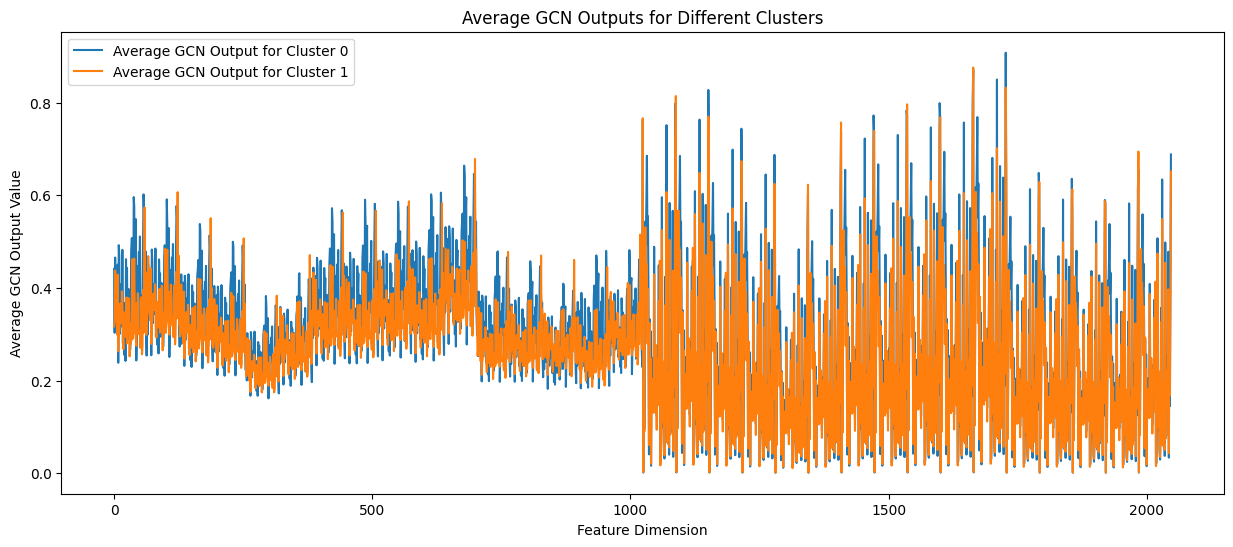

In [141]:
# prompt: plot sum_1 and sum_0
plt.figure(figsize=(15, 6))
plt.plot(sum_0.detach().numpy(), label='Average GCN Output for Cluster 0')
plt.plot(sum_1.detach().numpy(), label='Average GCN Output for Cluster 1')
plt.xlabel('Feature Dimension')
plt.ylabel('Average GCN Output Value')
plt.title('Average GCN Outputs for Different Clusters')
plt.legend()
plt.show()
